In [1]:
#Import necessary packages.

import numpy as np
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, LSTM, Activation, Embedding
from keras.models import load_model, Sequential
from keras.optimizers import Adam
import os
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
import json
import pandas as pd

%matplotlib inline

current_directory = os.getcwd()

/Accounts/huanga2/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Load datasets.

X_train = np.load("Training_data.npy")
X_test = np.load("Test_data.npy")
Y_train = np.load('Training_labels.npy')
Y_test = np.load('Test_labels.npy')
test_reference = np.load('Test_reference.npy')
human_train = np.load('Human_Test.npy')
human_test = np.load('Human_Test_Labels.npy')
human_data_reference = np.load('human_Data_Reference.npy')

human_test_dict = {}

for i in range(len(human_data_reference)):
    if human_data_reference[i][0] not in human_test_dict:
        human_test_dict[human_data_reference[i][0]] = [[], []]
    human_test_dict[human_data_reference[i][0]][0].append(human_train[i])
    human_test_dict[human_data_reference[i][0]][1].append(human_test[i])
for item in human_test_dict:
    human_test_dict[item][0] = np.array(human_test_dict[item][0])
    human_test_dict[item][1] = np.array(human_test_dict[item][1])
    
print(X_train.shape)
print(X_test.shape)
print(len(Y_train))
print(len(Y_test))


(469448, 512)
(53080, 512)
469448
53080


In [3]:
#Regularize the data.

mean = X_train.mean(axis = 0)
X_train -= mean
X_test -= mean
for item in human_test_dict:
    human_test_dict[item][0] -= mean 

std = X_train.std(axis = 0)
X_train /= std
X_test /= std
for item in human_test_dict:
    human_test_dict[item][0] /= std

In [4]:
#Group the conjecture-premise pair by group

test_dict = {} 

for i in range(len(X_test)):
    if test_reference[i][0] not in test_dict:
        test_dict[test_reference[i][0]] = [[],[]]
    
    test_dict[test_reference[i][0]][0].append(X_test[i])
    test_dict[test_reference[i][0]][1].append(Y_test[i])



In [125]:
#[OPTIONAL] Choose a smaller sample.

train_data_selection = int(X_train.shape[0]*0.1)
test_data_selection = int(X_test.shape[0]*0.1)

X_train = X_train[:train_data_selection]
Y_train = Y_train[:train_data_selection]
X_test = X_test[:test_data_selection]
Y_test = Y_test[:test_data_selection]

print(X_train.shape)
print(X_test.shape)
print(len(Y_train))
print(len(Y_test))

(47027, 512)
(5225, 512)
47027
5225


In [5]:

def findList(list1, list2, n):
    """This function will return the length less than integer n and its corresponding accuracy"""
    length_list = [] 
    acc_list = []
    for i in range(len(list1)):
        if list1[i] <= n:
            length_list.append(list1[i])
            acc_list.append(list2[i])
    return length_list,acc_list

In [7]:
#Find by length by average accuracy 
overall_result = {}
overall_result[256] = {}
overall_result[512] = {}
overall_result[1024] = {}
overall_result['LSTM'] = {}
#For 256 x 256, 512 x 512, 1024 x 1024 model

for l1 in range(8, 11):

    model = load_model('data/{}x{}_model.h5'.format(2 ** l1, 2 ** l1))

    for item in test_dict:
        
        test_loss, test_acc = model.evaluate(np.array(test_dict[item][0]), np.array(test_dict[item][1]), verbose = 2)
        if len(test_dict[item][0]) not in overall_result[2**l1]:
            overall_result[2**l1][len(test_dict[item][0])] = []
            #Append the accuracy to a list
        overall_result[2**l1][len(test_dict[item][0])].append(test_acc*100)
    #Find the average and reassign
    for item in overall_result[2**l1]:
        overall_result[2**l1][item] = sum(overall_result[2**l1][item])/len(overall_result[2**l1][item])

#For LSTM model
model = load_model('data/LSTMmodel.h5')
for item in test_dict:
    test_loss, test_acc = model.evaluate(np.array([[i] for i in test_dict[item][0]]), np.array([[i] for i in test_dict[item][1]]), verbose = 2)
    if len(test_dict[item][0]) not in overall_result['LSTM']:
        overall_result['LSTM'][len(test_dict[item][0])] = []
    overall_result['LSTM'][len(test_dict[item][0])].append(test_acc*100)
for item in overall_result['LSTM']:
    overall_result['LSTM'][item] = sum(overall_result['LSTM'][item])/len(overall_result['LSTM'][item])

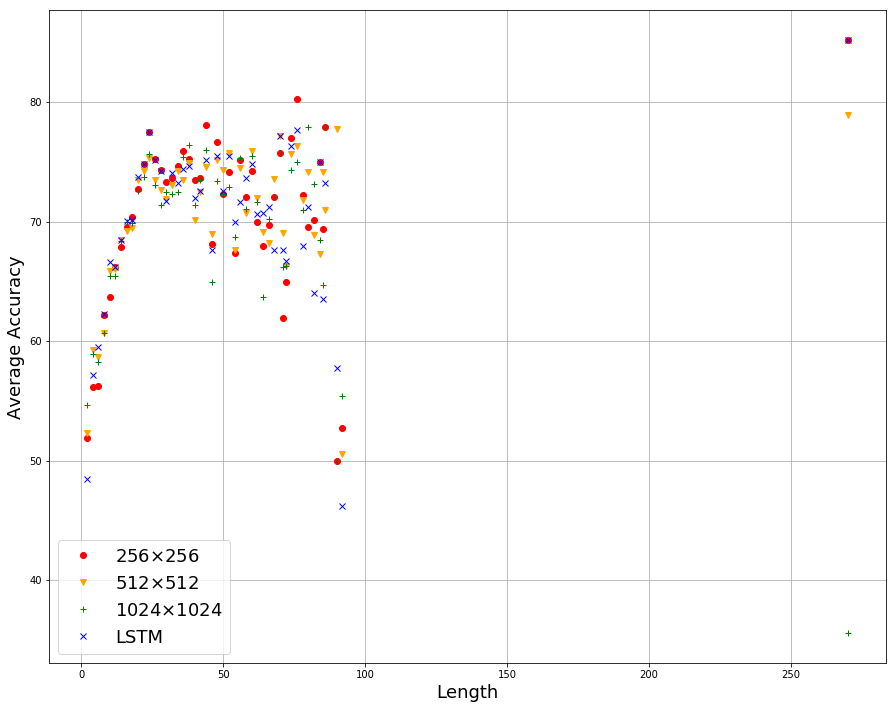

In [8]:
#Plot length by average accuracy

plt.rcParams['figure.figsize'] = 15, 12

n=30
length_256, acc_256 = findList(list(overall_result[256].keys()), list(overall_result[256].values()), n)

plt.plot(list(overall_result[256].keys()), list(overall_result[256].values()), 'o', label = '256' + r'$\times$' + '256', color="red")
plt.plot(list(overall_result[512].keys()), list(overall_result[512].values()), 'v', label = '512' + r'$\times$' + '512', color="orange")
plt.plot(list(overall_result[1024].keys()), list(overall_result[1024].values()), '+', label = '1024' + r'$\times$' + '1024', color="green")
plt.plot(list(overall_result['LSTM'].keys()), list(overall_result['LSTM'].values()), 'x', label = 'LSTM', color="blue")

plt.xlabel('Length', fontsize = 18)
plt.ylabel('Average Accuracy', fontsize = 18)
plt.grid()
plt.legend(fontsize = 18)
plt.show()



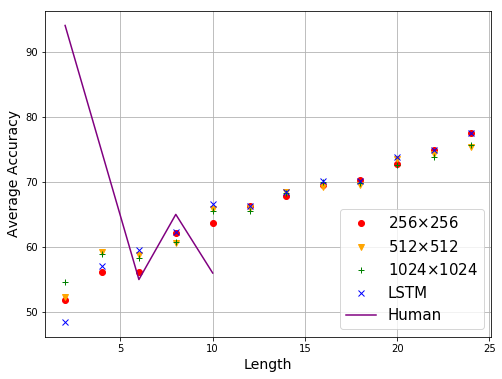

In [9]:
#Fidn the average accuracy with length less than 25, and plot the smae graph.
#Also, add the human's accuracy to the graph

plt.rcParams['figure.figsize'] = 8,6

human_length = [2, 6, 8, 10]
human_acc = [94, 55, 65, 56]

n = 25

length_256, acc_256 = findList(list(overall_result[256].keys()), list(overall_result[256].values()), n)
plt.plot(length_256, acc_256, 'o', label = '256' + r'$\times$' + '256', color="red")

length_512, acc_512 = findList(list(overall_result[512].keys()), list(overall_result[512].values()), n)
                               
                               
plt.plot(length_512, acc_512, 'v', label = '512' + r'$\times$' + '512', color="orange")

length_1024, acc_1024 = findList(list(overall_result[1024].keys()), list(overall_result[1024].values()), n)
plt.plot(length_1024, acc_1024, '+', label = '1024' + r'$\times$' + '1024', color="green")

length_LSTM, acc_LSTM = findList(list(overall_result['LSTM'].keys()), list(overall_result['LSTM'].values()), n)
plt.plot(length_LSTM, acc_LSTM, 'x', label = 'LSTM', color="blue")
plt.plot(human_length, human_acc, label = 'Human', color="purple")


plt.xlabel('Length', fontsize = 14)
plt.ylabel('Average Accuracy', fontsize = 14)
plt.grid()
plt.legend(fontsize = 15)
plt.show()


In [10]:
#Fidn the correlation. 
corr_256 = np.corrcoef(length_256, acc_256)
corr_512 = np.corrcoef(length_512, acc_512)
corr_1024 = np.corrcoef(length_1024, acc_1024)
corr_LSTM = np.corrcoef(length_LSTM, acc_LSTM)
print(corr_256)
print(corr_512)
print(corr_1024)
print(corr_LSTM)

[[1.         0.98726135]
 [0.98726135 1.        ]]
[[1.         0.97382104]
 [0.97382104 1.        ]]
[[1.         0.98544907]
 [0.98544907 1.        ]]
[[1.         0.96160272]
 [0.96160272 1.        ]]


[[ 1.         -0.27767696]
 [-0.27767696  1.        ]]


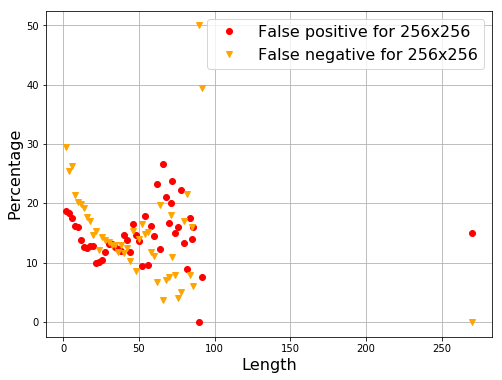

[[ 1.         -0.50270867]
 [-0.50270867  1.        ]]


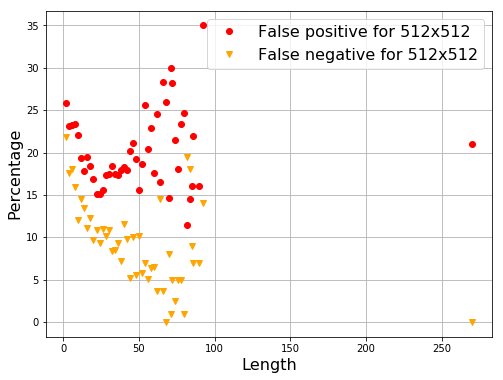

[[1.         0.37792567]
 [0.37792567 1.        ]]


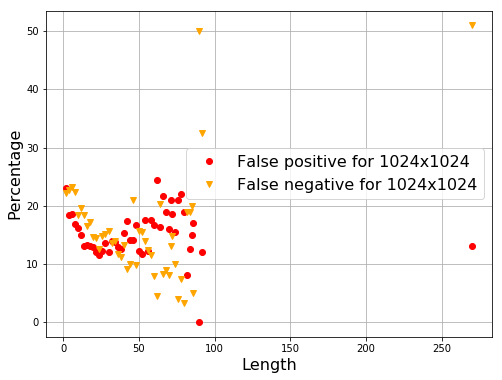

In [11]:
#Find the false positive percentile and false negative percentile for 256 x 256, 512 x 512, and 1024 x 1024
for l1 in range(8, 11):
    model = load_model('data/{}x{}_model.h5'.format(2 ** l1, 2 ** l1))
    false_pos = {}
    false_neg = {}

    for item in test_dict:
        
        if len(test_dict[item][0]) not in false_pos:
            false_pos[len(test_dict[item][0])] = []
        if len(test_dict[item][0]) not in false_neg:
            false_neg[len(test_dict[item][0])] = []

        predictions = model.predict(np.array(test_dict[item][0])) >= 0.5
        mislabeled_pos = np.zeros(np.array(test_dict[item][0]).shape[0])
        mislabeled_neg = np.zeros(np.array(test_dict[item][0]).shape[0])
        
        #Find the false_pos and false_neg
        for m in range(mislabeled_pos.shape[0]):
            if test_dict[item][1][m] == 0 and predictions[m] == [True]:
                mislabeled_pos[m] = 1
            if test_dict[item][1][m] == 1 and predictions[m] == [False]:
                mislabeled_neg[m] = 1
        #Find the percentile
                
        per_pos = np.sum(mislabeled_pos) / mislabeled_pos.shape[0]
        per_neg = np.sum(mislabeled_neg) / mislabeled_neg.shape[0]
        
        false_pos[len(test_dict[item][0])].append(round(per_pos,2))
        false_neg[len(test_dict[item][0])].append(round(per_neg,2))
    #Find the average percentile 
    for item in false_pos:
        false_pos[item] = sum(false_pos[item])/len(false_pos[item])
        false_neg[item] = sum(false_neg[item])/len(false_neg[item])
    #Plot the diagram
    plt.plot(list(false_pos.keys()), np.array(list(false_pos.values()))*100, 'o', label = 'False positive for {}x{}'.format(2 ** l1, 2 ** l1), color="red")
    plt.plot(list(false_neg.keys()), np.array(list(false_neg.values()))*100, 'v', label = 'False negative for {}x{}'.format(2 ** l1, 2 ** l1), color="orange")
    print(np.corrcoef(list(false_neg.keys()), list(false_neg.values())))
    
    plt.xlabel('Length', fontsize = 16)
    plt.ylabel('Percentage', fontsize = 16)
    plt.grid()
    plt.legend(fontsize = 16)
    plt.show()



[[ 1.         -0.44551483]
 [-0.44551483  1.        ]]


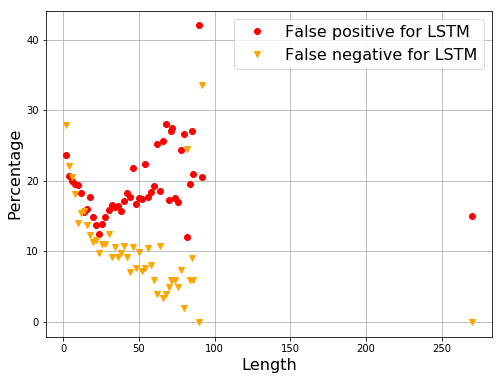

In [12]:
#Find the false positive percentile and false negative percentile for LSTM.
model = load_model('data/LSTMmodel.h5'.format(2 ** l1, 2 ** l1))
false_pos = {}
false_neg = {}

for item in test_dict:
        
    if len(test_dict[item][0]) not in false_pos:
        false_pos[len(test_dict[item][0])] = []
    if len(test_dict[item][0]) not in false_neg:
        false_neg[len(test_dict[item][0])] = []

    predictions = model.predict(np.array([[i] for i in test_dict[item][0]])) >= 0.5
    mislabeled_pos = np.zeros(np.array(test_dict[item][0]).shape[0])
    mislabeled_neg = np.zeros(np.array(test_dict[item][0]).shape[0])
    for m in range(mislabeled_pos.shape[0]):
        if test_dict[item][1][m] == 0 and predictions[m] == [True]:
            mislabeled_pos[m] = 1
        if test_dict[item][1][m] == 1 and predictions[m] == [False]:
            mislabeled_neg[m] = 1
                
    per_pos = np.sum(mislabeled_pos) / mislabeled_pos.shape[0]
    per_neg = np.sum(mislabeled_neg) / mislabeled_neg.shape[0]
        
    false_pos[len(test_dict[item][0])].append(round(per_pos,2))
    false_neg[len(test_dict[item][0])].append(round(per_neg,2))
        
for item in false_pos:
    false_pos[item] = sum(false_pos[item])/len(false_pos[item])
    false_neg[item] = sum(false_neg[item])/len(false_neg[item])
        
plt.plot(list(false_pos.keys()), np.array(list(false_pos.values()))*100, 'o', label = 'False positive for LSTM', color="red")
plt.plot(list(false_neg.keys()), np.array(list(false_neg.values()))*100, 'v', label = 'False negative for LSTM', color="orange")
print(np.corrcoef(list(false_neg.keys()), list(false_neg.values())))
  
plt.xlabel('Length', fontsize = 16)
plt.ylabel('Percentage', fontsize = 16)
plt.grid()
plt.legend(fontsize = 16)
plt.show()